<a href="https://www.kaggle.com/code/khawajaabaidullah/ps3e6-setting-upper-bounds-may-help?scriptVersionId=119024298" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pathlib import Path
import lightgbm as lgbm
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.preprocessing import OrdinalEncoder

In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
# setting a base path variable for easy access
BASE_PATH = Path("/kaggle/input/playground-series-s3e6")
train = pd.read_csv(BASE_PATH / "train.csv").drop(columns=["id"])
# for the purose of demonstrating differences in this notebook, we're creating a copy of dataframe
train_2 = train.copy()

test = pd.read_csv(BASE_PATH / "test.csv")
test_idx = test.id
test = test.drop(columns=["id"])
test_2 = test.copy()

In [4]:
numerical_features = [col for col in train.columns if train[col].nunique() > 20]
# excluding price
numerical_features = numerical_features[:-1]

# Before setting the upper bounds

## Numerical features distribution

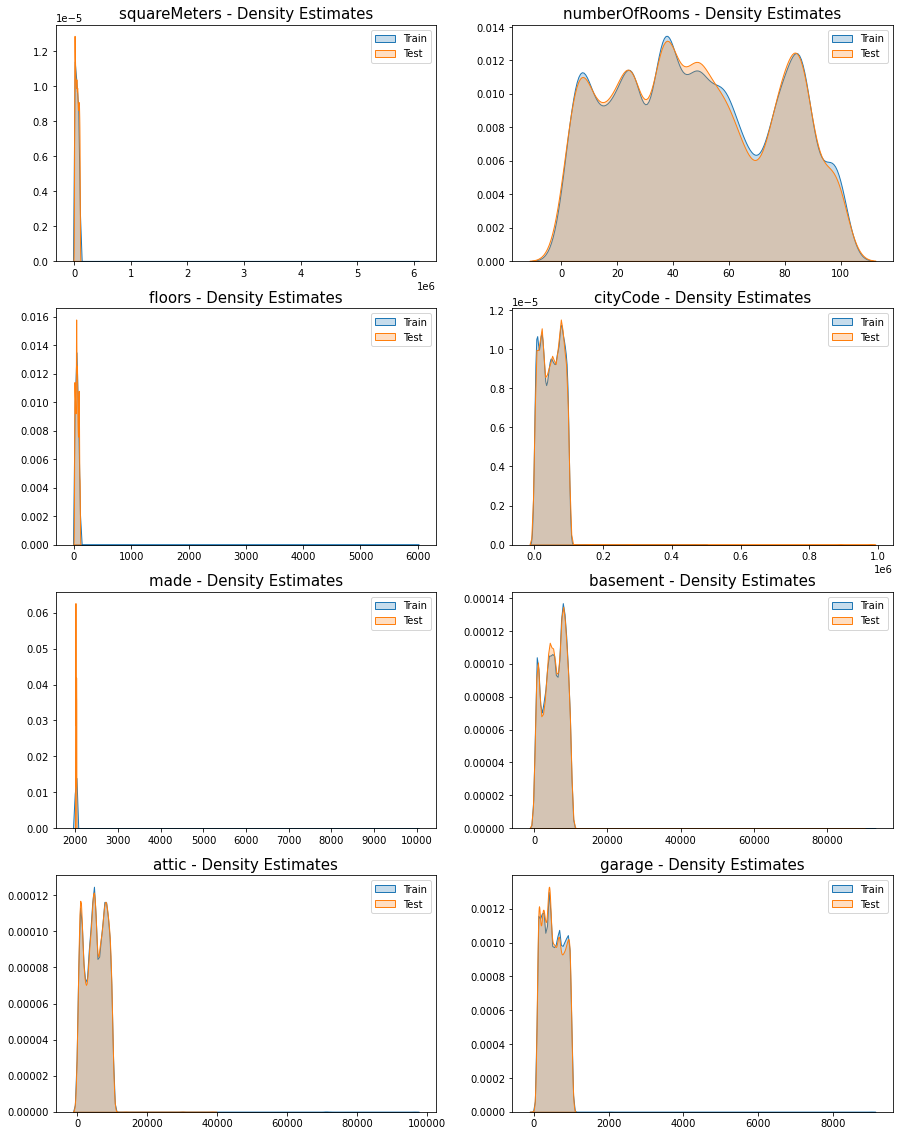

In [5]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axs = axs.flatten()

for ax_counter, feature in enumerate(numerical_features):
    _ = sns.kdeplot(train[feature], shade=True, ax=axs[ax_counter], label="Train")
    _ = sns.kdeplot(test[feature], shade=True, ax=axs[ax_counter], label="Test")
    
    _ = axs[ax_counter].set_title("{} - Density Estimates".format(feature), fontsize=15)
    _ = axs[ax_counter].set_ylabel("")
    _ = axs[ax_counter].set_xlabel("")
    
    handles, labels = axs[ax_counter].get_legend_handles_labels()
    axs[ax_counter].legend(handles=handles, labels=labels, title="")

### INSIGHTS: These look very skewed becaused of outliers. Setting bounds should help here!

# Categorical features distributions

In [6]:
categorical_features = [col for col in train.columns if train[col].nunique() < 20]
categorical_features

['hasYard',
 'hasPool',
 'cityPartRange',
 'numPrevOwners',
 'isNewBuilt',
 'hasStormProtector',
 'hasStorageRoom',
 'hasGuestRoom']

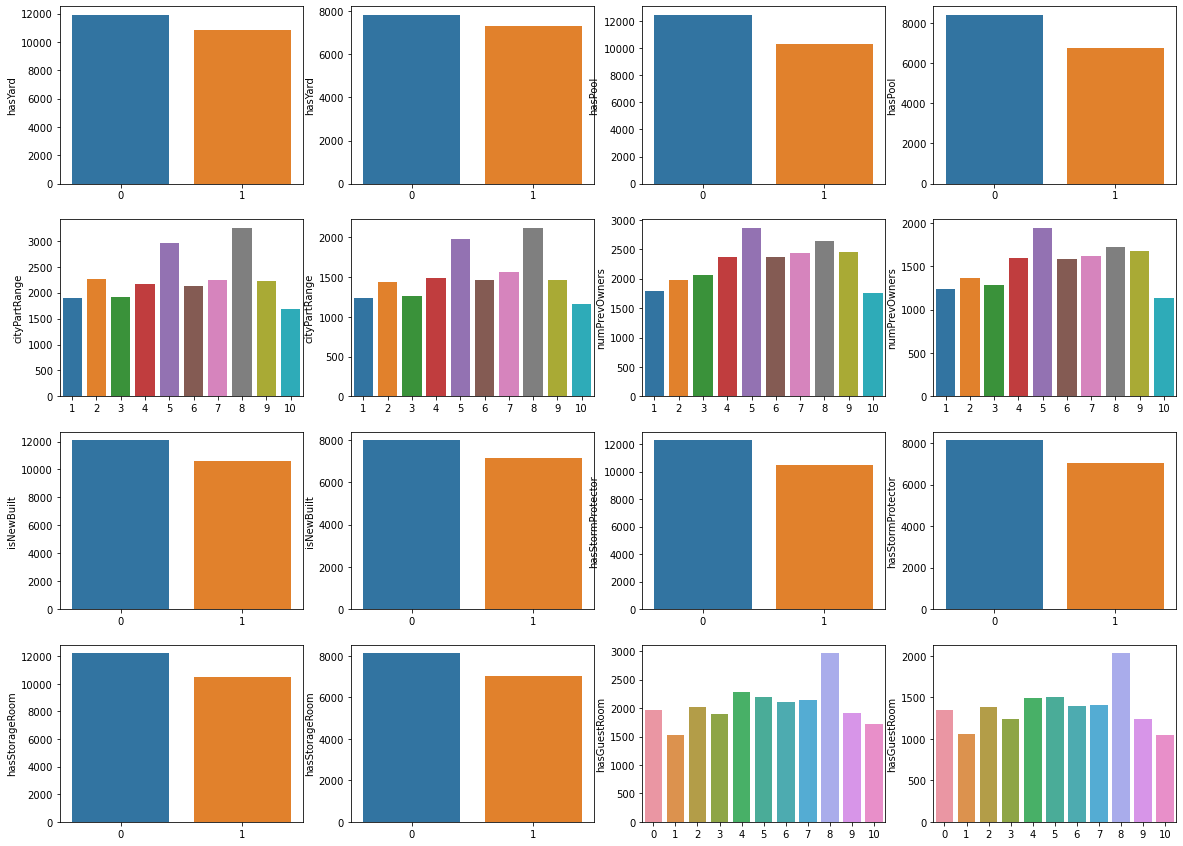

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
axs = axs.flatten()

ax_counter = 0
for feature in categorical_features:
    counts = pd.DataFrame(train[feature].value_counts())
    _ = sns.barplot(x=counts.index, y=counts[feature],
                   ax=axs[ax_counter], label="train")
    ax_counter += 1
    
    counts = pd.DataFrame(test[feature].value_counts())
    _ = sns.barplot(x=counts.index, y=counts[feature],
                   ax=axs[ax_counter], label="test")
    ax_counter += 1


#### INSIGHTS: These look fine. So we dont need to set any bounds for these categorical features.

## Encoding + Preprocessing

In [8]:
def encode_categorical(train, test):
    oe = OrdinalEncoder()
    train[categorical_features] = oe.fit_transform(train[categorical_features])
    test[categorical_features] = oe.transform(test[categorical_features])
    return train, test

In [9]:
train, test = encode_categorical(train, test)
X, y = train.drop(columns="price"), train.price

## Cross Validating

In [10]:
def cross_validate_lgbm(X, y):
    N_FOLDS = 5
    cv_scores = np.zeros(N_FOLDS)
    
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)
    
    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = lgbm.LGBMRegressor()
        
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=50,
                  eval_metric="rmse",
                 verbose=-1)
        
        y_preds = model.predict(X_val)
        
        # to calculate rmse instead of mse, we set squared=False
        rmse = mean_squared_error(y_val, y_preds, squared=False)
        cv_scores[fold_num] = rmse        
        print(f"Fold {fold_num} \t RMSE: {rmse}")
        
    avg_rmse = np.mean(cv_scores)
    print(f"AVG RMSE: {avg_rmse}")

In [11]:
cross_validate_lgbm(X, y)

Fold 0 	 RMSE: 169410.45032032923
Fold 1 	 RMSE: 132249.73024736258
Fold 2 	 RMSE: 133168.19074826475
Fold 3 	 RMSE: 251895.71308501367
Fold 4 	 RMSE: 159952.15709558927
AVG RMSE: 169335.2482993119


# Setting Upper Bounds
If you're wondering how i found these upper bounds, I used pandas' nlargest method.
> **dataframe[feature].nlargest(N)**

and spotted manually where the upper bound should be.
I haven't included these implementation details because I feel like they would clutter the notebook while providing little to no benefit to the reader.

In [12]:
train_2["attic"] = train_2.attic.clip(upper=10000)
test_2["attic"] = test_2.attic.clip(upper=10000)

train_2["floors"] = train_2.floors.clip(upper=100)
test_2["floors"] = test_2.floors.clip(upper=100)


train_2["squareMeters"] = train_2.squareMeters.clip(upper=100000)
test_2["squareMeters"] = test_2.squareMeters.clip(upper=100000)

train_2["made"] = train_2.made.clip(upper=2021)
test_2["made"] = test_2.made.clip(upper=2021)

train_2["basement"] = train_2.basement.clip(upper=10000)
test_2["basement"] = test_2.basement.clip(upper=10000)

train_2["garage"] = train_2.garage.clip(upper=1000)
test_2["garage"] = test_2.garage.clip(upper=1000)

train_2["cityCode"] = train_2.cityCode.clip(upper=99999)
test_2["cityCode"] = test_2.cityCode.clip(upper=99999)

# After setting the upper bounds


## Numerical Feature Distribution

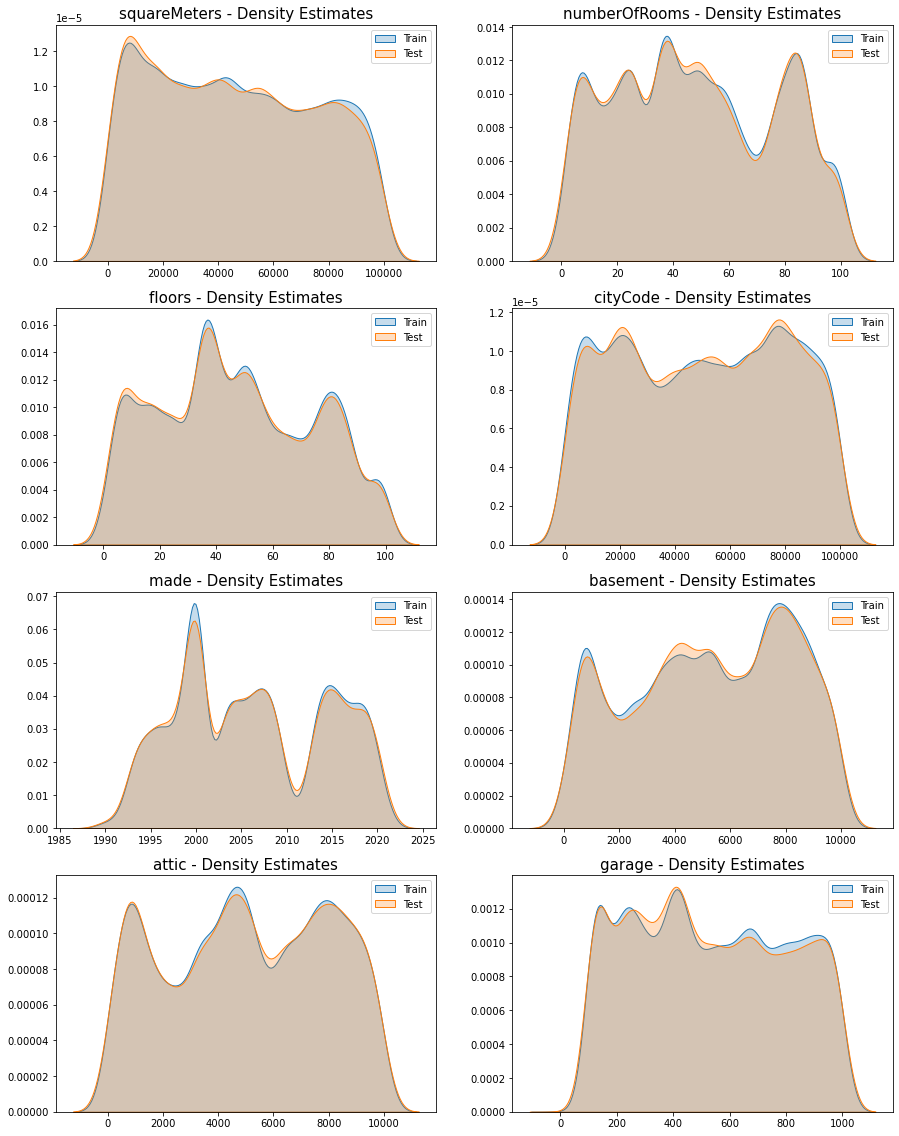

In [13]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axs = axs.flatten()

for ax_counter, feature in enumerate(numerical_features):
    _ = sns.kdeplot(train_2[feature], shade=True, ax=axs[ax_counter], label="Train")
    _ = sns.kdeplot(test_2[feature], shade=True, ax=axs[ax_counter], label="Test")
    
    _ = axs[ax_counter].set_title("{} - Density Estimates".format(feature), fontsize=15)
    _ = axs[ax_counter].set_ylabel("")
    _ = axs[ax_counter].set_xlabel("")
    
    handles, labels = axs[ax_counter].get_legend_handles_labels()
    axs[ax_counter].legend(handles=handles, labels=labels, title="")

### INSIGHTS: Much better! We can now easily grasp the distribution similarities and differences, visually.

In [14]:
train_2, test_2 = encode_categorical(train_2, test_2)
X_2, y_2 = train_2.drop(columns="price"), train_2.price

In [15]:
cross_validate_lgbm(X_2, y_2)

Fold 0 	 RMSE: 169410.45032032923
Fold 1 	 RMSE: 132249.73024736258
Fold 2 	 RMSE: 133168.19074826475
Fold 3 	 RMSE: 251895.71308501367
Fold 4 	 RMSE: 159952.15709558927
AVG RMSE: 169335.2482993119


# Conclusion:
Sure, setting these upper bounds doesn't improve score **DIRECTLY** but they do carry the potential to improve your score when you use other techniques that base on the aggregation of features and are sensitive to the mean values of the feature. For example, if you're filling missing values with the mean of a feature. As I've shown in my other notebook: **[Hunting Hidden Outliers using Common Sense](https://www.kaggle.com/khawajaabaidullah/ps3e6-hunting-hidden-outliers-using-common-sense/)**.

Also, setting these upper bounds helps better grasp the distribution similarities and differences of features between the training and test set.